In [1]:
import os,sys
import math

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from functools import reduce

import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold,cross_val_predict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sys.path.append("../../../src")  # adjust path as needed
from data_loader import LoadData
from model import MlModels
from evaluation import Evaluate

### MRI and Demographic Data

### Load the Data

In [2]:
# --- Load data
mri_data_path = "/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/clean_data/PDMRI_Clean_Merged_6_13_25.csv"
gene_data_path = "/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/clean_data/gene_expression_summary.csv"
nhy_latest_path = "/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/clean_data/clean_mds_updrs.csv"

dataload_mri_cls = LoadData(input_updrs=nhy_latest_path,
    input_gene_clinical=gene_data_path,
    input_mri=mri_data_path,
    mri_data=True,
    gene_data=False,
    group_NHY=True,
    group_binary=True,
    common_dataset=True,
    stratify_splits=True)

X_data, Y_data = dataload_mri_cls.merged_data()

X shape: (712, 110), Y shape: (712, 1)
Y class distribution: {(1.0,): 434, (0.0,): 278}
['rh_MeanThickness', 'rh_WhiteSurfArea', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_White_Matter', 'CerebralWhiteMatterVol', 'rhSurfaceHoles', 'lhSurfaceHoles']


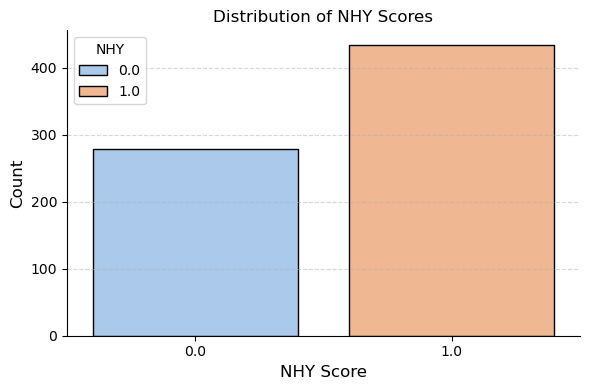

In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x='NHY', data=Y_data, hue='NHY', palette='pastel', edgecolor='black')
plt.title("Distribution of NHY Scores", fontsize=12)
plt.xlabel("NHY Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

### Split the data

In [4]:
X_train, Y_train, X_cv, Y_cv, X_test, Y_test = dataload_mri_cls.data_split(X_data, Y_data)
data = {}
data['X_train'] = X_train
data['Y_train'] = Y_train

### Logistic Regression model

In [5]:
models_list =['logistic', 'logistic_cv']
class_weight_list = [None, 'balanced']
models_dict = {}

for mo_l in models_list:
    for cw in class_weight_list:
        names_ = f"model_{mo_l}_{cw}"
        models_dict[names_] = (mo_l, cw)

trained_models = {}
for name, (model_type, cw) in models_dict.items():
    if model_type == 'logistic_cv':
        params_cv = {'cv':StratifiedKFold(n_splits=5)}
        
        mymodel = MlModels(model_name = model_type, 
                        data=data, params = params_cv, 
                        pca_flag=False, class_weights=cw)
    else:
        mymodel = MlModels(model_name = model_type, 
                        data=data, params = None, 
                        pca_flag=False, class_weights=cw)
    mymodel.build_model()
    trained_models[name] = mymodel


/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [6]:
eval_objs = {}
eval_results = {}

for model_type in models_list:
    for cw in class_weight_list:
        key = f"{model_type}_{cw}"
        model_key = f"model_{model_type}_{cw}"
        
        # Create Evaluate object
        eval_objs[key] = Evaluate(trained_models[model_key], X_cv, Y_cv)
        
        # Run and store results
        print(f"\n📌 Model: {model_key.replace('model_', '').replace('_', ' ').title()}\n{'=' * 50}")
        eval_results[key] = eval_objs[key].report_validation_metrics()


📌 Model: Logistic None

✅ Validation Accuracy: 0.6512

📋 Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0.0          │       0.667 │    0.235 │      0.348 │    34     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1.0          │       0.649 │    0.923 │      0.762 │    52     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │       0.651 │    0.651 │      0.651 │     0.651 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │       0.658 │    0.579 │      0.555 │    86     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │       0.656 │    0.651 │      0.598 │    86     │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

🧩 Confusion Matrix:
╒═══╤═══╤════╕
│ 0 │ 8 │ 26

### Final Model

In [7]:
X_train, Y_train, X_cv, Y_cv, X_test, Y_test = dataload_mri_cls.data_split(X_data, Y_data)

#Train using the X_train and X_cv
X_train_full = pd.concat([X_train, X_cv])
Y_train_full = pd.concat([Y_train, Y_cv])

data_final = {}
data_final['X_train'] = X_train_full
data_final['Y_train'] = Y_train_full

params_final = {'penalty': 'l2'}
        
final_model = MlModels(model_name = 'logistic', 
                    data=data_final, params = params_final, 
                    pca_flag=False, class_weights=None)

final_model.build_model()
final_trained_model = final_model

#Show the accuracy
eval_obj_final = Evaluate(final_trained_model, X_test, Y_test)
print(f"\n📌 Model: Logistic Regression")

eval_results_final = eval_obj_final.report_validation_metrics()


📌 Model: Logistic Regression

✅ Validation Accuracy: 0.6643

📋 Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0.0          │       0.786 │    0.196 │      0.314 │    56     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1.0          │       0.651 │    0.966 │      0.778 │    87     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │       0.664 │    0.664 │      0.664 │     0.664 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │       0.718 │    0.581 │      0.546 │   143     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │       0.704 │    0.664 │      0.596 │   143     │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

🧩 Confusion Matrix:
╒═══╤════╤════╕
│ 0 │

### Demographic, Gene Expressions and MRI

In [8]:
# --- Load data
mri_data_path = "/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/clean_data/PDMRI_Clean_Merged_6_13_25.csv"
gene_data_path = "/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/clean_data/gene_expression_summary.csv"
nhy_latest_path = "/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/clean_data/clean_mds_updrs.csv"

dataload_all_cls = LoadData(input_updrs=nhy_latest_path,
    input_gene_clinical=gene_data_path,
    input_mri=mri_data_path,
    mri_data=True,
    gene_data=True,
    group_NHY=True,
    group_binary=True,
    common_dataset=True,
    stratify_splits=True)

X_data, Y_data = dataload_all_cls.merged_data()

X shape: (712, 110), Y shape: (712, 1)
Y class distribution: {(1.0,): 434, (0.0,): 278}


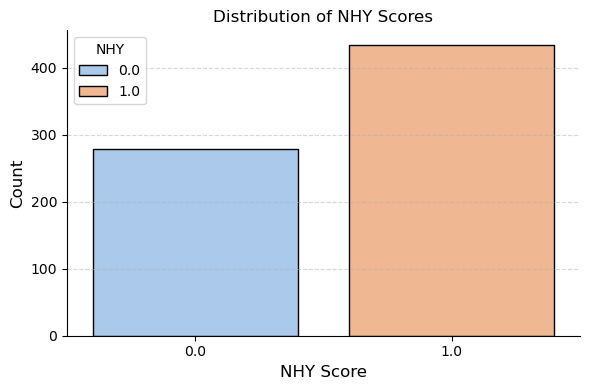

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='NHY', data=Y_data, hue='NHY', palette='pastel', edgecolor='black')
plt.title("Distribution of NHY Scores", fontsize=12)
plt.xlabel("NHY Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

In [10]:
X_train, Y_train, X_cv, Y_cv, X_test, Y_test = dataload_all_cls.data_split(X_data, Y_data)
data_all = {}
data_all['X_train'] = X_train
data_all['Y_train'] = Y_train

In [11]:
models_list =['logistic', 'logistic_cv']
class_weight_list = [None, 'balanced']
models_dict = {}

for mo_l in models_list:
    for cw in class_weight_list:
        names_ = f"model_{mo_l}_{cw}"
        models_dict[names_] = (mo_l, cw)

trained_models_all = {}
for name, (model_type, cw) in models_dict.items():
    if model_type == 'logistic_cv':
        params = {'cv':StratifiedKFold(n_splits=5), 
                    'penalty': 'l2'}
    else:
        params = {'penalty': 'l2'}
        
    mymodel_all = MlModels(model_name = model_type, 
                        data=data_all, params = params, 
                        pca_flag=False, class_weights=cw)
    mymodel_all.build_model()
    trained_models_all[name] = mymodel_all

/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [12]:
eval_objs = {}
eval_results = {}

for model_type in models_list:
    for cw in class_weight_list:
        key = f"{model_type}_{cw}"
        model_key = f"model_{model_type}_{cw}"
        
        # Create Evaluate object
        eval_objs[key] = Evaluate(trained_models_all[model_key], X_cv, Y_cv)
        
        # Run and store results
        print(f"\n📌 Model: {model_key.replace('model_', '').replace('_', ' ').title()}\n{'=' * 50}")
        eval_results[key] = eval_objs[key].report_validation_metrics()


📌 Model: Logistic None

✅ Validation Accuracy: 0.5698

📋 Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0.0          │       0.452 │    0.412 │      0.431 │     34    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1.0          │       0.636 │    0.673 │      0.654 │     52    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │       0.57  │    0.57  │      0.57  │      0.57 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │       0.544 │    0.542 │      0.542 │     86    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │       0.563 │    0.57  │      0.566 │     86    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

🧩 Confusion Matrix:
╒═══╤════╤════╕
│ 0 │ 14 │ 

### Test Set

In [13]:
X_train, Y_train, X_cv, Y_cv, X_test, Y_test = dataload_all_cls.data_split(X_data, Y_data)

eval_objs_test = {}
eval_results_test = {}

for model_type in models_list:
    for cw in class_weight_list:
        key = f"{model_type}_{cw}"
        model_key = f"model_{model_type}_{cw}"
        
        # Create Evaluate object
        eval_objs_test[key] = Evaluate(trained_models_all[model_key], X_cv, Y_cv)
        
        # Run and store results
        print(f"\n📌 Model: {model_key.replace('model_', '').replace('_', ' ').title()}\n{'=' * 50}")
        eval_results_test[key] = eval_objs_test[key].report_validation_metrics()


📌 Model: Logistic None

✅ Validation Accuracy: 0.5698

📋 Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0.0          │       0.452 │    0.412 │      0.431 │     34    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1.0          │       0.636 │    0.673 │      0.654 │     52    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │       0.57  │    0.57  │      0.57  │      0.57 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │       0.544 │    0.542 │      0.542 │     86    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │       0.563 │    0.57  │      0.566 │     86    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

🧩 Confusion Matrix:
╒═══╤════╤════╕
│ 0 │ 14 │ 

### Final Model

In [14]:
#Train using the X_train and X_cv
X_train_full = pd.concat([X_train, X_cv])
Y_train_full = pd.concat([Y_train, Y_cv])

data_all_final = {}
data_all_final['X_train'] = X_train_full
data_all_final['Y_train'] = Y_train_full

params_final = {'penalty': 'l2'}
        
final_model = MlModels(model_name = 'logistic', 
                    data=data_all_final, params = params_final, 
                    pca_flag=False, class_weights=None)

final_model.build_model()
final_trained_model = final_model

#Show the accuracy
eval_obj_final = Evaluate(final_trained_model, X_test, Y_test)
print(f"\n📌 Model: Logistic Regression")

eval_results_final = eval_obj_final.report_validation_metrics()




📌 Model: Logistic Regression

✅ Validation Accuracy: 0.6224

📋 Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0.0          │       0.529 │    0.321 │      0.4   │    56     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1.0          │       0.651 │    0.816 │      0.724 │    87     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │       0.622 │    0.622 │      0.622 │     0.622 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │       0.59  │    0.569 │      0.562 │   143     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │       0.604 │    0.622 │      0.597 │   143     │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛

🧩 Confusion Matrix:
╒═══╤════╤════╕
│ 0 │

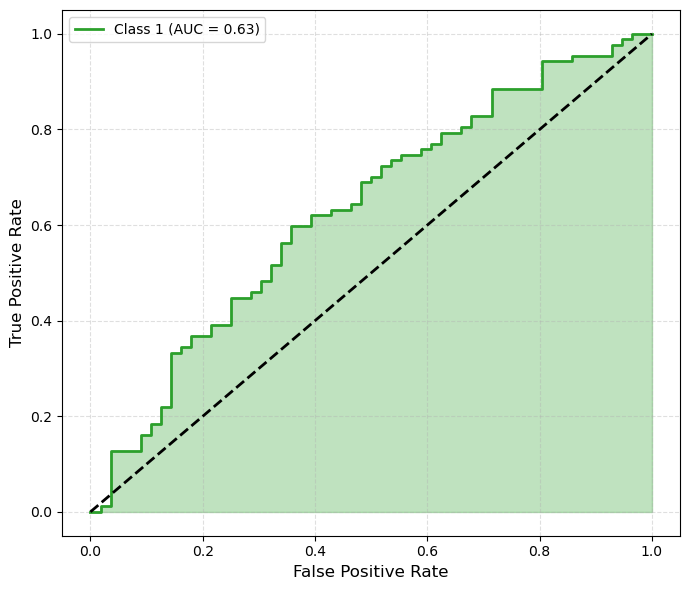

In [ ]:
# Get the AUC output dictionary
eval_auc = eval_obj_final.get_auc_scores(class_list=[0, 1])

fpr = eval_auc['fpr']
tpr = eval_auc['tpr']
roc_auc = eval_auc['roc_auc']
auc_score = eval_auc['auc_score']

plt.figure(figsize=(7, 6))

for i in fpr:
    plt.plot(fpr[i], tpr[i], lw=2, color='tab:green', label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.fill_between(fpr[i], 0, tpr[i], color='tab:green', alpha=0.3)

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(linestyle='--', alpha=0.4)
plt.tight_layout()


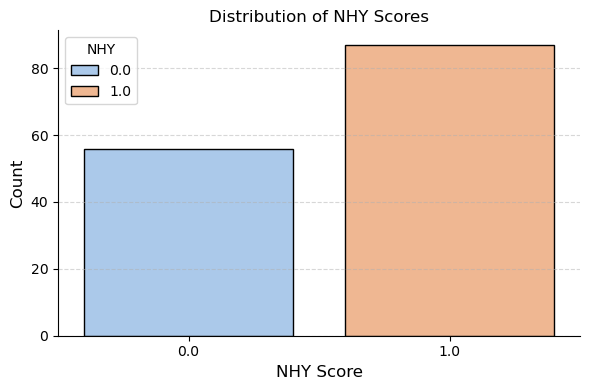

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='NHY', data=Y_test.to_frame(name='NHY'), hue='NHY', palette='pastel', edgecolor='black')
plt.title("Distribution of NHY Scores", fontsize=12)
plt.xlabel("NHY Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
y_score = eval_obj_final.predict_proba(eval_obj_final.x_test)
print(y_score.shape)

(143, 2)
